In [18]:
import importlib
importlib.reload(cluster_util)
import cluster_util

# Notebook error analysis 

## Refining error types - Vectorization and clustering method selection


use a subset of the dedupped GitHub error dataset with ename == valueerror

## Test the retrained word2vec/subword2vec vs. GloVe

on Optics

In [7]:
import pandas as pd 
import config
import cluster_util
import numpy as np

df_err_gvalue = pd.read_excel(config.path_github_cluster_valueerr)
# df_err_gvalue["evalue_tokenized"] = df_err_gvalue.evalue.apply(cluster_util.preprocess_text)
df_err_gvalue = df_err_gvalue[(~df_err_gvalue.evalue.isnull()) & (df_err_gvalue["evalue_tokenized"]!="")]
err_descs = df_err_gvalue['evalue_tokenized'].values.astype('U')

In [8]:
len(df_err_gvalue)

1807

In [9]:
glove_vectors = cluster_util.load_glove(config.path_default.joinpath("glove.6B/glove.6B.200d.txt"))
X_glove = np.array([cluster_util.vectorizer_word2vec(xi, glove_vectors, 200) for xi in err_descs])
n_components = cluster_util.select_pca_n_basedon_variance(X_glove)
X_glove_rd = cluster_util.pca(X_glove, n_components=n_components)
df_err_gvalue.loc[:,"cluster_optics_glove"] = cluster_util.cluster_optics(X_glove_rd, min_samples = 2)

Loaded 400000 word vectors from GloVe.
pca: 48 components can explain 80.01% variance of the data
Estimated no. of clusters: 268
Estimated no. of noise points: 1034


C:\Users\yirwa29\AppData\Local\anaconda3\envs\chatgpt\Lib\site-packages\sklearn\cluster\_optics.py:1081: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


In [10]:
import retrain_word2vec,config

def cluster_with_w2v(model_name="nberr_word2vec.model", res_col_name="cluster_optics_w2v", var_cutoff=0.8, min_sam=2):
    w2v_model = retrain_word2vec.load_word2vec(config.path_w2v_models, model_name)
    X_w2v = np.array([cluster_util.vectorizer_word2vec(xi, w2v_model.wv, w2v_model.vector_size) for xi in err_descs])
    n_components = cluster_util.select_pca_n_basedon_variance(X_w2v, variance_cutoff=var_cutoff)
    X_w2v_rd = cluster_util.pca(X_w2v, n_components=n_components)
    df_err_gvalue.loc[:,res_col_name] = cluster_util.cluster_optics(X_w2v_rd, min_samples = min_sam)
    
    return cluster_util.eval_cluster_silhouette(X_w2v_rd[df_err_gvalue[res_col_name]!=-1],
                                        df_err_gvalue.loc[df_err_gvalue[res_col_name]!=-1, res_col_name])

sq_w2v = cluster_with_w2v()
sq_w2v_sg = cluster_with_w2v(model_name="nberr_word2vec_sg.model", res_col_name="cluster_optics_w2v_sg")
sq_w2v_finetune = cluster_with_w2v(model_name="nberr_word2vec_glove_finetune.model", res_col_name="cluster_optics_w2v_finetune")
sq_w2v_subword2vec = cluster_with_w2v(model_name="nberr_subword2vec.model", res_col_name="cluster_optics_w2v_subword2vec")
sq_w2v_subword2vec_finetune = cluster_with_w2v(model_name="nberr_subword2vec_finetune.model", res_col_name="cluster_optics_w2v_subword2vec_finetune")

pca: 59 components can explain 80.00% variance of the data


C:\Users\yirwa29\AppData\Local\anaconda3\envs\chatgpt\Lib\site-packages\sklearn\cluster\_optics.py:1081: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Estimated no. of clusters: 285
Estimated no. of noise points: 1023
pca: 68 components can explain 80.20% variance of the data


C:\Users\yirwa29\AppData\Local\anaconda3\envs\chatgpt\Lib\site-packages\sklearn\cluster\_optics.py:1081: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Estimated no. of clusters: 297
Estimated no. of noise points: 977
pca: 20 components can explain 80.64% variance of the data


C:\Users\yirwa29\AppData\Local\anaconda3\envs\chatgpt\Lib\site-packages\sklearn\cluster\_optics.py:1081: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Estimated no. of clusters: 317
Estimated no. of noise points: 938
pca: 32 components can explain 80.28% variance of the data


C:\Users\yirwa29\AppData\Local\anaconda3\envs\chatgpt\Lib\site-packages\sklearn\cluster\_optics.py:1081: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Estimated no. of clusters: 327
Estimated no. of noise points: 899
pca: 84 components can explain 80.15% variance of the data


C:\Users\yirwa29\AppData\Local\anaconda3\envs\chatgpt\Lib\site-packages\sklearn\cluster\_optics.py:1081: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Estimated no. of clusters: 284
Estimated no. of noise points: 1000


In [11]:
df_err_gvalue_optics_w2v = df_err_gvalue[['fname','evalue','evalue_tokenized','traceback',
               'cluster_optics_glove','cluster_optics_w2v','cluster_optics_w2v_sg',
               'cluster_optics_w2v_finetune','cluster_optics_w2v_subword2vec','cluster_optics_w2v_subword2vec_finetune']]
# df_err_gvalue_optics_w2v.to_excel(config.path_w2v_models.joinpath("nberror_gvalueerror_w2v.xlsx"), index=False, engine='xlsxwriter')

In [12]:
ss_lev_glove, sum_lev_glove = cluster_util.statistics_lev(df_err_gvalue_optics_w2v, "cluster_optics_glove","evalue")
ss_lev_w2v, sum_lev_w2v = cluster_util.statistics_lev(df_err_gvalue_optics_w2v, "cluster_optics_w2v","evalue")
ss_lev_w2v_sg, sum_lev_w2v_sg = cluster_util.statistics_lev(df_err_gvalue_optics_w2v, "cluster_optics_w2v_sg","evalue")
ss_lev_w2v_finetune, sum_lev_w2v_finetune = cluster_util.statistics_lev(df_err_gvalue_optics_w2v, "cluster_optics_w2v_finetune","evalue")
ss_lev_subword2vec, sum_lev_subword2vec = cluster_util.statistics_lev(df_err_gvalue_optics_w2v, "cluster_optics_w2v_subword2vec","evalue")
ss_lev_subword2vec_finetune, sum_lev_subword2vec_finetune = cluster_util.statistics_lev(df_err_gvalue_optics_w2v, "cluster_optics_w2v_subword2vec_finetune","evalue")

In [13]:
arr_eval = np.zeros((4,6))
name_cols = ['word2vec_glove','word2vec_retrain','word2vec_retrain_sg','word2vec_finetune','word2vec_subword','word2vec_subword_finetune']
name_rows = ['optics_sh','optics_lev','optics_lev_std','n_noise']

#ss_optics_glove
sh_glove = cluster_util.eval_cluster_silhouette(X_glove_rd[df_err_gvalue_optics_w2v['cluster_optics_glove']!=-1],
                                                df_err_gvalue_optics_w2v.loc[df_err_gvalue_optics_w2v['cluster_optics_glove']!=-1, 'cluster_optics_glove'])
arr_eval[:,0] = [sh_glove]+sum_lev_glove

#ss_optics_retrain
arr_eval[:,1] = [sq_w2v]+sum_lev_w2v
arr_eval[:,2] = [sq_w2v_sg]+sum_lev_w2v_sg
arr_eval[:,3] = [sq_w2v_finetune]+sum_lev_w2v_finetune
arr_eval[:,4] = [sq_w2v_subword2vec]+sum_lev_subword2vec
arr_eval[:,5] = [sq_w2v_subword2vec_finetune]+sum_lev_subword2vec_finetune

pd.DataFrame(arr_eval, index=name_rows, columns=name_cols)

,word2vec_glove,word2vec_retrain,word2vec_retrain_sg,word2vec_finetune,word2vec_subword,word2vec_subword_finetune
optics_sh,0.444906,0.415568,0.404909,0.384396,0.443866,0.416406
optics_lev,0.676546,0.670702,0.670205,0.626191,0.607081,0.662491
optics_lev_std,0.041100,0.039133,0.046976,0.044246,0.047247,0.047497
n_noise,0.572219,0.566132,0.540675,0.519092,0.497510,0.553403


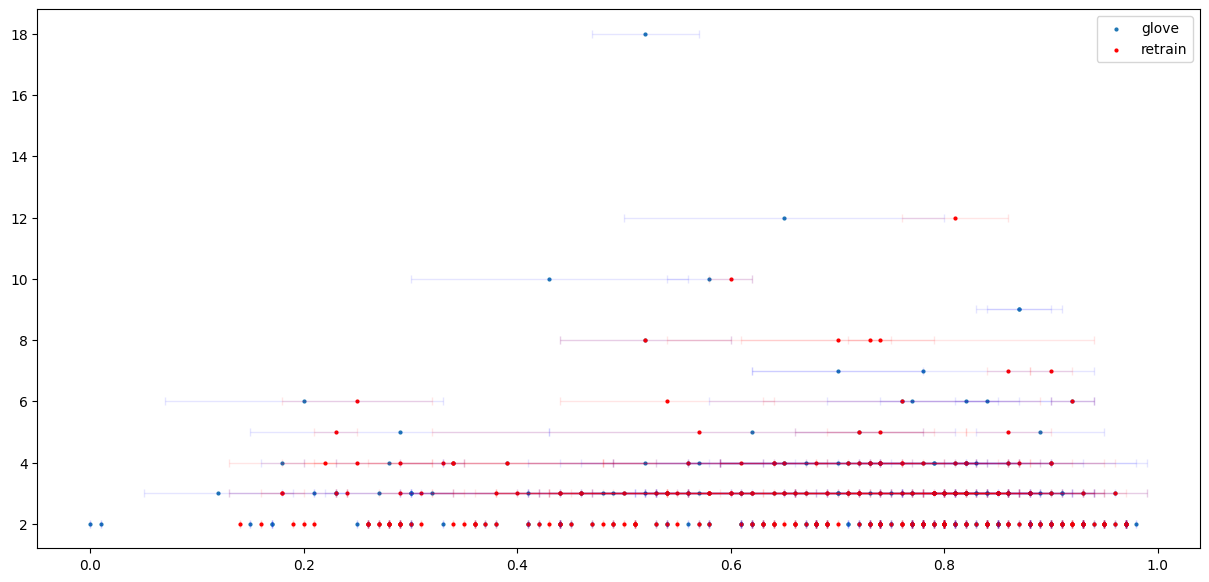

In [14]:
import matplotlib.pyplot as plt
import math

fig, ax = plt.subplots(figsize=(15, 7))
ax.scatter(ss_lev_glove['mean_similarity'], ss_lev_glove.cluster_size, label = 'glove', s=4)
ax.errorbar(ss_lev_glove['mean_similarity'], ss_lev_glove.cluster_size, xerr=ss_lev_glove['std_similarity'], 
             lw=1, capsize=3, ecolor=(0.0,0.0,1.0,0.1), ls='none')

ax.scatter(ss_lev_w2v['mean_similarity'], ss_lev_w2v.cluster_size, label = 'retrain', s=4, color="r")
ax.errorbar(ss_lev_w2v['mean_similarity'], ss_lev_w2v.cluster_size, xerr=ss_lev_w2v['std_similarity'], 
             lw=1, capsize=3, ecolor=(1.0,0.0,0.0,0.1), ls='none')
ax.legend()
plt.show()